In [1]:
import torch
import numpy as np
from transformers import AutoProcessor, XCLIPVisionModel
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from torchvision.transforms import RandomResizedCrop,  Compose, Normalize, ToTensor, Resize

In [6]:
# We hosted dataset zipfile under github release to access it easily with code
import pooch
zipfile_name = pooch.retrieve(
    url="https://github.com/tornikeo/imigue-classification/releases/download/data/training.zip",
    known_hash=None,
)

SHA256 hash of downloaded file: 32f3cf0ad0f91fd03f7eaead1144919f19038b905f820d9a18a69e4ccbc19306
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [7]:
import os
import zipfile
import pooch
from pathlib import Path

# Create the directory for extracted files
raw_data_dir = Path("data/raw")
raw_data_dir.mkdir(exist_ok=True)

# Extract the contents of the zip file into the target directory
with zipfile.ZipFile(zipfile_name, 'r') as zip_ref:
    zip_ref.extractall(raw_data_dir)

print("Zip file extracted successfully.")

Zip file extracted successfully.


We rename directories from 1-32, to 0-31 to be consistent.

In [18]:
# Iterate over each directory inside raw_data_dir

for directory in (raw_data_dir / 'training').iterdir():
    if directory.is_dir():
        # Get the current directory name
        current_name = directory.name
        
        # Extract the integer part of the directory name
        try:
            directory_number = int(current_name)
        except ValueError:
            continue  # Skip if the directory name is not a valid integer
        
        # Rename the directory to x-1 format
        new_name = str(directory_number - 1)
        new_directory = (raw_data_dir / 'training') / new_name
        directory.rename(new_directory)
        print(directory, '->', new_directory)
        
print("Directories renamed successfully.")

data/raw/training/1 data/raw/training/0
data/raw/training/2 data/raw/training/1
data/raw/training/3 data/raw/training/2
data/raw/training/4 data/raw/training/3
data/raw/training/5 data/raw/training/4
data/raw/training/6 data/raw/training/5
data/raw/training/7 data/raw/training/6
data/raw/training/8 data/raw/training/7
data/raw/training/9 data/raw/training/8
data/raw/training/10 data/raw/training/9
data/raw/training/11 data/raw/training/10
data/raw/training/12 data/raw/training/11
data/raw/training/13 data/raw/training/12
data/raw/training/14 data/raw/training/13
data/raw/training/15 data/raw/training/14
data/raw/training/16 data/raw/training/15
data/raw/training/17 data/raw/training/16
data/raw/training/18 data/raw/training/17
data/raw/training/19 data/raw/training/18
data/raw/training/20 data/raw/training/19
data/raw/training/21 data/raw/training/20
data/raw/training/22 data/raw/training/21
data/raw/training/23 data/raw/training/22
data/raw/training/24 data/raw/training/23
data/raw/tr

In [1]:
from pathlib import Path
import pandas as pd

processed_data_dir = Path('data/processed')
processed_data_dir.mkdir(exist_ok=True)
raw_data_dir = Path('data/raw/training')
images = tuple(sorted(Path(raw_data_dir).glob('**/*.jpg')))
images[:10]

(PosixPath('data/raw/training/0/10116.0.jpg'),
 PosixPath('data/raw/training/0/10116.1.jpg'),
 PosixPath('data/raw/training/0/10116.10.jpg'),
 PosixPath('data/raw/training/0/10116.11.jpg'),
 PosixPath('data/raw/training/0/10116.12.jpg'),
 PosixPath('data/raw/training/0/10116.13.jpg'),
 PosixPath('data/raw/training/0/10116.2.jpg'),
 PosixPath('data/raw/training/0/10116.3.jpg'),
 PosixPath('data/raw/training/0/10116.4.jpg'),
 PosixPath('data/raw/training/0/10116.5.jpg'))

In [31]:
data_dir = Path('data')

def parse_meta(image: Path) -> tuple:
    video_id, frame_id = image.stem.split('.')
    class_id = image.parent.name
    rel_path = Path(*image.parts[3:])
    return str(rel_path), int(class_id), int(video_id), int(frame_id)
    
meta = [parse_meta(image) for image in tqdm(images)]
meta = pd.DataFrame(meta, columns=['file_name', 'label', 'video', 'frame'])

df = pd.read_csv(data_dir/'id2label.csv')
full_meta = pd.merge(meta, df, left_on='label', right_on='id')
# full_meta.to_csv(processed_data_dir / 'metadata.csv', index=None)

full_meta

  0%|          | 0/60514 [00:00<?, ?it/s]

100%|██████████| 60514/60514 [00:00<00:00, 171365.30it/s]


,file_name,label,video,frame,id,id2label,id2category
0,0/10116.0.jpg,0,10116,0,0,Turtle neck,Head
1,0/10116.1.jpg,0,10116,1,0,Turtle neck,Head
2,0/10116.10.jpg,0,10116,10,0,Turtle neck,Head
3,0/10116.11.jpg,0,10116,11,0,Turtle neck,Head
4,0/10116.12.jpg,0,10116,12,0,Turtle neck,Head
...,...,...,...,...,...,...,...
60509,9/2517.3.jpg,9,2517,3,9,Biting nails,Head-hand
60510,9/2517.4.jpg,9,2517,4,9,Biting nails,Head-hand
60511,9/2517.5.jpg,9,2517,5,9,Biting nails,Head-hand
60512,9/2517.6.jpg,9,2517,6,9,Biting nails,Head-hand


We make a new dataset structure with proper labels.

In [34]:
import os
import shutil

# Function to normalize directory name
def normalize_directory_name(name):
    return name.lower().replace(' ', '_')

# Iterate over each row in full_meta
for index, row in tqdm(full_meta.iterrows()):
    # Get the file name and label
    file_name = row['file_name']
    label = row['id2label']
    
    # Normalize the directory name
    directory_name = normalize_directory_name(label)
    
    # Create the target directory if it doesn't exist
    target_directory = processed_data_dir / directory_name
    target_directory.mkdir(parents=True, exist_ok=True)
    
    # Copy the file to the target directory
    shutil.copy(data_dir / 'raw/training' / file_name, target_directory)

print("Files copied successfully.")

60514it [00:10, 5804.04it/s]

Files copied successfully.


In [2]:
from datasets import load_dataset

data = load_dataset(str(processed_data_dir),  num_proc=32)

Resolving data files:   0%|          | 0/60514 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/32 [00:00<?, ?it/s]

In [4]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60514
    })
})

# Visuals

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

full_meta.id2label.value_counts().plot.bar()
plt.ylabel('Number of samples')
plt.yscale('log')
plt.show()

NameError: name 'full_meta' is not defined

In [6]:
full_meta.groupby('id2label').size().plot.bar()
plt.ylabel('Number of samples')
plt.yscale('log')
plt.show()

NameError: name 'full_meta' is not defined

In [7]:
full_meta.groupby('id2label').video.nunique().plot.bar()
plt.ylabel('Number of VIDEOS')
plt.yscale('log')
plt.show()

NameError: name 'full_meta' is not defined

In [16]:
## Does any one FRAME have more than one label
full_meta.groupby('file_name').label.nunique().max() > 1

False

In [17]:
## Does any one VIDEO have more than one label
full_meta.groupby('video').label.nunique().max() > 1

True

In [18]:
# How many such videos?
(full_meta.groupby('video').label.nunique() > 1).sum()

1

Text(0.5, 0, 'Index of video')

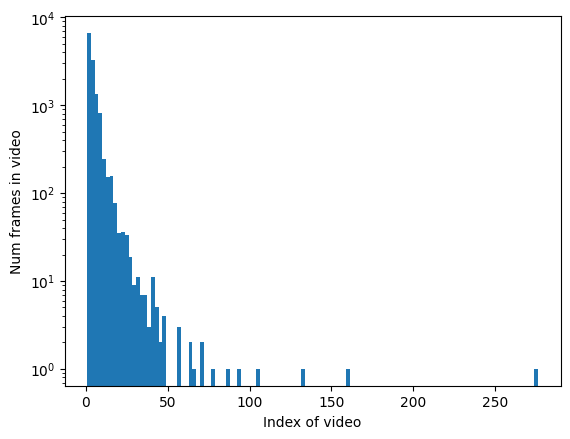

In [34]:
# How many frames per video? Quantiles
full_meta.groupby('video').frame.nunique().plot.hist(bins=120)
plt.ylabel("Num frames in video")
plt.yscale('log')
plt.xlabel("Index of video")

In [41]:
# Do we like... have a lot of gaps in video ids? What's number of video ids that we skip in dataset?
((full_meta.video.max() - full_meta.video.min()) - full_meta.video.nunique())

4717

We have to split by video! This means, every video must either be fully in test, or in train. No in-betweens.  
This is because every video is usually only one class. As a model, if you remember video, you can remember label too. That's not good.

In [42]:
from IPython.display import display

# How many videos do we have?
print("=== How many videos do we have?")

display(meta.video.nunique())
# What's the quantiles for num frames per video?
print("=== Frames per video")
display(meta.groupby('video').frame.nunique().describe())

print("=== Frames per video")
# Can we have one video in multiple classes? Yes right?
print("=== Can we have one video in multiple classes?")
display(meta.groupby('video').label.nunique().describe())
print("Most yes, but some videos have two labels")

=== How many videos do we have?


12910

=== Frames per video


count    12910.000000
mean         4.687374
std          5.550717
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        276.000000
Name: frame, dtype: float64

=== Frames per video
=== Can we have one video in multiple classes?


count    12910.000000
mean         1.000077
std          0.008801
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: label, dtype: float64

Most yes, but some videos have two labels


In [45]:
print(full_meta.head().to_markdown())

|    | file_name      |   label |   video |   frame | id2label    | id2category   |
|---:|:---------------|--------:|--------:|--------:|:------------|:--------------|
|  0 | 1/10116.0.jpg  |       1 |   10116 |       0 | Turtle neck | Head          |
|  1 | 1/10116.1.jpg  |       1 |   10116 |       1 | Turtle neck | Head          |
|  2 | 1/10116.10.jpg |       1 |   10116 |      10 | Turtle neck | Head          |
|  3 | 1/10116.11.jpg |       1 |   10116 |      11 | Turtle neck | Head          |
|  4 | 1/10116.12.jpg |       1 |   10116 |      12 | Turtle neck | Head          |


random train_test_split, so that every video is either in train or test exclusively to prevent data leak. Also, the labels are unbalanced, some classes (like 32) lave ~10^4 entries and smallest class has only 10 entries (also, the same class has only one video in it too, this is label 19).

All videos must be exclusively in train or test. Except the label 19, in this case it should be split in half and first video half should go into train and second into test.


In [7]:
full_meta

,file_name,label,video,frame,id2label,id2category
0,1/10116.0.jpg,1,10116,0,Turtle neck,Head
1,1/10116.1.jpg,1,10116,1,Turtle neck,Head
2,1/10116.10.jpg,1,10116,10,Turtle neck,Head
3,1/10116.11.jpg,1,10116,11,Turtle neck,Head
4,1/10116.12.jpg,1,10116,12,Turtle neck,Head
...,...,...,...,...,...,...
60509,9/8751.1.jpg,9,8751,1,Touching ears,Head-hand
60510,9/8751.2.jpg,9,8751,2,Touching ears,Head-hand
60511,9/970.0.jpg,9,970,0,Touching ears,Head-hand
60512,9/970.2.jpg,9,970,2,Touching ears,Head-hand


In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Stratified train-test split on remaining data
video_labels = full_meta.groupby('video').label.first().reset_index()
cols = video_labels.columns
row_to_duplicate = video_labels[video_labels.label == 19]
video_labels = np.array(video_labels).tolist().append(np.array(video_labels[video_labels.label == 19]).tolist())
video_labels = pd.DataFrame(videl_labels, columns=cols)
train_vids, test_vids = train_test_split(video_labels, 
                                         test_size=0.2, 
                                         stratify=video_labels.label,
                                         random_state=42)
train_vids

,video,label
2004,3101,24
6966,10484,32
2782,4358,32
12730,17524,32
3094,4679,22
...,...,...
4318,6486,24
9143,12738,31
187,336,29
10093,13719,32


In [9]:
data.push_to_hub('TornikeO/imigue')

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/20172 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/202 [00:00<?, ?ba/s]

Map:   0%|          | 0/20171 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/202 [00:00<?, ?ba/s]

Map:   0%|          | 0/20171 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/202 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/TornikeO/imigue/commit/c6b2825d938b2d7a33b87d5806e4f29653c520d4', commit_message='Upload dataset', commit_description='', oid='c6b2825d938b2d7a33b87d5806e4f29653c520d4', pr_url=None, pr_revision=None, pr_num=None)